# Importing the libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import os


In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [6]:
df['Target'].unique()

array(['Graduate', 'Dropout', 'Enrolled'], dtype=object)

# Preprocessing Data

In [7]:
X = df.drop('Target', axis=1)
y = df['Target']

In [8]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=0)

# Train the Model

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualification                 

In [11]:
numeric_features = ['Application order','Admission grade','Curricular units 1st sem (credited)', 'Age at enrollment',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', 'Unemployment rate',
       'Inflation rate', 'GDP']

categorical_features = ['Marital status', 'Application mode',
       'Course', 'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International',]


numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [12]:
params = {
        'classifier__catboost__iterations': 64,
        'classifier__catboost__learning_rate': 0.2652277204594899,
        'classifier__catboost__depth': 10,
        'classifier__catboost__l2_leaf_reg': 8.948239338694481,

        'classifier__xgb__n_estimators': 397,
        'classifier__xgb__learning_rate': 0.051027317155483524,
        'classifier__xgb__max_depth': 8,
        'classifier__xgb__min_child_weight': 6,

        'classifier__lightgbm__n_estimators': 60,
        'classifier__lightgbm__learning_rate': 0.18441323110797328,
        'classifier__lightgbm__num_leaves': 81,
        'classifier__lightgbm__max_depth': 10,
    }

catboost_clf = CatBoostClassifier(random_state=42, iterations=100, verbose=0)
xgb_clf = XGBClassifier(random_state=42, n_estimators=100)
lgbm_clf = LGBMClassifier(random_state=42, n_estimators=100)


# Create VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('catboost', catboost_clf),
        ('xgb', xgb_clf),
        ('lightgbm', lgbm_clf),
    ],
    voting='soft')
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", voting_clf)]
)

clf.set_params(**params)

clf.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1485
[LightGBM] [Info] Number of data points in the train set: 61214, number of used features: 224
[LightGBM] [Info] Start training from score -1.106764
[LightGBM] [Info] Start training from score -1.632975
[LightGBM] [Info] Start training from score -0.746494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Application order',
                                                   'Admission grade',
                                                   'Curricular units 1st sem '
                                                   '(credited)',
                                                   'Age at enrollment',
                                                   'Curricular units 1st sem '
                                                   '(enrolled)',
                                                   'Curricular units 1st sem '
                                                   '(evaluations)',
                                                   'Curricular units 1st sem '
                                                   '(approved)',
                                                   'Curricular units 1st sem '
                                                   '(grade)...
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=8,
                                                             max_leaves=None,
                                                             min_child_weight=6,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=397,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                              ('lightgbm',
                                               LGBMClassifier(learning_rate=0.18441323110797328,
                                                              max_depth=10,
                                                              n_estimators=60,
                                                              num_leaves=81,
                                                              random_state=42))],
                                  voting='soft'))])

# Evaluate the Model

In [13]:
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
print(accuracy_score(y_test, y_pred))
print(report)

0.8310245687401986
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      5057
           1       0.65      0.61      0.63      2982
           2       0.85      0.92      0.89      7265

    accuracy                           0.83     15304
   macro avg       0.80      0.79      0.79     15304
weighted avg       0.83      0.83      0.83     15304



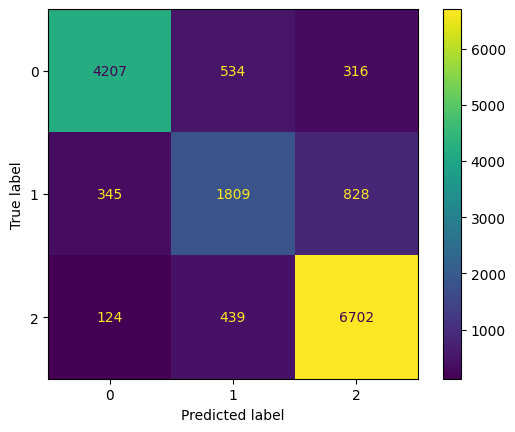

In [14]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()


# Test Set Prediction

In [15]:
test_df = pd.read_csv('test.csv')

In [16]:
from re import sub
test = test_df
ids = test_df['id']
test_pred = clf.predict(test)
test_pred = label_encoder.inverse_transform(test_pred)
submission = pd.DataFrame({'id': ids, 'Target': test_pred})
submission.to_csv('submission.csv', index=False)